In [1]:
import numpy as np
import sys
sys.path.insert(0, '../') 
from RNN_model_GRAD import *
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
try:
    import ujson as json
except ImportError:
    import json
import scipy.linalg as slin
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib as mpl
from numba import jit, njit
import scipy
from dca.dca import DynamicalComponentsAnalysis as DCA
from sklearn.linear_model import Ridge as RR
from sklearn.metrics import r2_score
from scipy.linalg import subspace_angles
from sklearn.decomposition import PCA

# Random Networks

## PI vs Dimensionality for different nonlinearities and g-factors

**Setup Variables**

In [133]:
num_avg = 10
max_dim=8
ds = np.arange(1,max_dim+1)
gs = np.arange(0.7,1.7,0.1)
thetas = np.arange(0,np.pi/4+np.pi/50, np.pi/20)
num_nodes = 256
time_constant=100
timestep=10
time = 10000
init_activations = tf.constant(np.zeros((num_nodes, 1)))
#dont care about the output
output_weight_matrix = tf.constant(np.zeros((1, num_nodes)))
connectivity_matrix = np.ones((num_nodes, num_nodes))
noise_strength = 0.01

def noise(time):
    return np.sqrt(2 * time_constant/timestep) * noise_strength * np.random.normal(0, 1)

input_funcs = [noise]
input_weight_matrix = tf.constant(np.ones((1,num_nodes)))

**Computing PIs (Only run once)**

In [51]:
pis_mean = []
pis_std = []
for g in gs:
    print('g = {0}'.format(g), flush=True)
    pis_per_angle_mean=[]
    pis_per_angle_std = []
    for theta in thetas:
        pis_to_avg=[]
        for idx in tqdm(range(num_avg)):
            weight_matrix = np.random.normal(0, g/np.sqrt(num_nodes), (num_nodes, num_nodes))
            network = RNN(weight_matrix, connectivity_matrix, init_activations, output_weight_matrix, time_constant = time_constant,
                     timestep = timestep, activation_func = tf.keras.layers.LeakyReLU(alpha=np.tan(theta)), output_nonlinearity = lambda x : x)
            inputs = network.convert(time, input_funcs)
            _,activations = network.simulate(time, inputs, input_weight_matrix, disable_progress_bar = True) 
            activations = [activation.numpy() for activation in activations]
            activations = np.asarray(activations)
            pis_per_dim = np.zeros(ds.size)
            dca_model = DCA(T=10, d=256)
            dca_model.estimate_data_statistics(activations)
            for ii, dim in enumerate(ds):
                dca_model.fit_projection(d=dim)
                pis_per_dim[ii] = dca_model.score()
            pis_to_avg.append(pis_per_dim)
        pis_per_angle_mean.append(np.mean(pis_to_avg,axis=0))
        pis_per_angle_std.append(np.std(pis_to_avg,axis=0))
    pis_mean.append(pis_per_angle_mean)
    pis_std.append(pis_per_angle_std)    

g = 1.2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [13:22<00:00, 80.27s/it]

g = 1.3



100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [19:23<00:00, 116.35s/it]

g = 1.4000000000000001



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [12:06<00:00, 72.61s/it]

g = 1.5000000000000002



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [10:37<00:00, 63.70s/it]

g = 1.6000000000000003



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [18:19<00:00, 109.95s/it]


In [52]:
pis_mean_prev = np.load('random_net_mean_pis.npy').tolist()
pis_std_prev = np.load('random_net_std_pis.npy').tolist()

for row in pis_mean:
    pis_mean_prev.append(row)
for row in pis_std:
    pis_std_prev.append(row)
pis_mean=pis_mean_prev
pis_std=pis_std_prev

In [53]:
pis_mean = np.array(pis_mean)
pis_std = np.array(pis_std)

#np.save('random_net_mean_pis', pis_mean)
#np.save('random_net_std_pis', pis_std)

**Plotting Results**

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


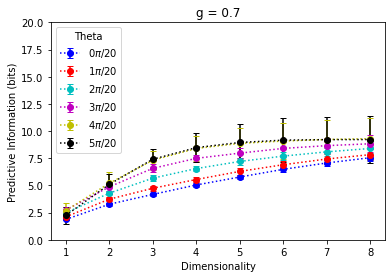

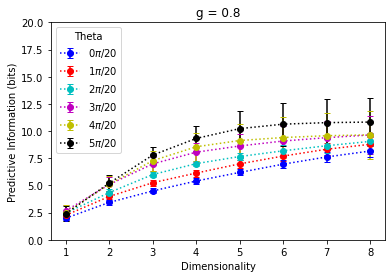

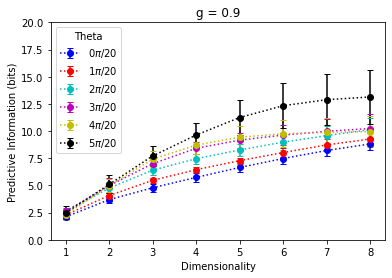

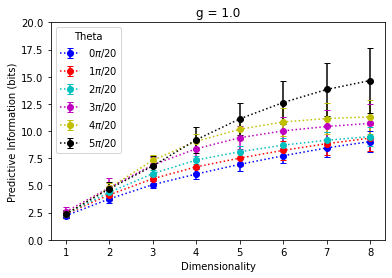

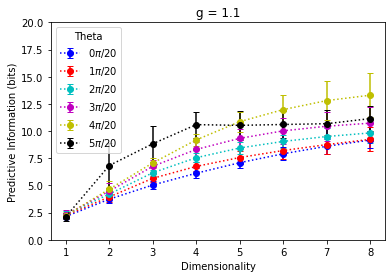

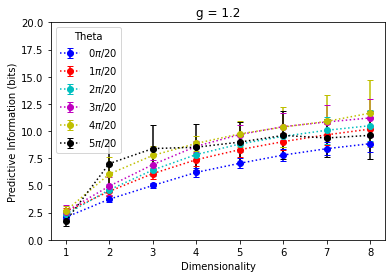

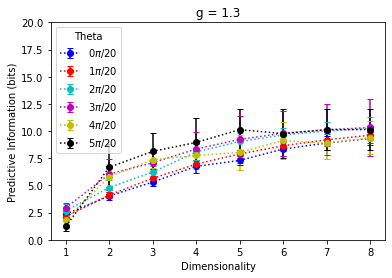

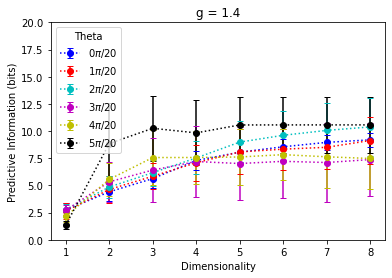

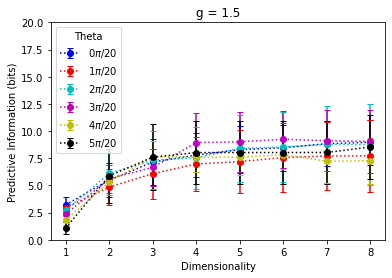

In [55]:
formats=['bo:','ro:','co:','mo:','yo:','ko:']
pis_mean = np.load('random_net_mean_pis.npy')
pis_std = np.load('random_net_std_pis.npy')
for idx in range(gs.size):
    fig, ax = plt.subplots()
    plt.xlabel('Dimensionality')
    plt.ylabel('Predictive Information (bits)')
    plt.title('g = {0}'.format(round(gs[idx],1)))
    for idx2 in range(thetas.size):
        ax.errorbar(ds, pis_mean[idx, idx2], yerr=pis_std[idx,idx2],capsize=3,fmt=formats[idx2], label=r'{0}$\pi/20$'.format(idx2))
        
    plt.legend(title='Theta')
    plt.ylim(0,20)
    fig.show()

### Plotting maxPI vs nonlinearity and g-factor

**Computing PIS (only run once)**

In [134]:
max_pis_mean = []
max_pis_std = []
gs = np.arange(0.9, 1.52, 0.05)
num_avg = 10
for g in gs:
    print('g = {0}'.format(g), flush=True)
    pis_per_angle_mean=[]
    pis_per_angle_std = []
    for theta in tqdm(thetas):
        pis_to_avg=[]
        for idx in range(num_avg):
            weight_matrix = np.random.normal(0, g/np.sqrt(num_nodes), (num_nodes, num_nodes))
            network = RNN(weight_matrix, connectivity_matrix, init_activations, output_weight_matrix, time_constant = time_constant,
                     timestep = timestep, activation_func = tf.keras.layers.LeakyReLU(alpha=np.tan(theta)), output_nonlinearity = lambda x : x)
            inputs = network.convert(time, input_funcs)
            _,activations = network.simulate(time, inputs, input_weight_matrix, disable_progress_bar = True) 
            activations = [activation.numpy() for activation in activations]
            activations = np.asarray(activations)
            dca_model = DCA(T=10, d=256)
            dca_model.estimate_data_statistics(activations)
            max_pi = dca_model.score()
            pis_to_avg.append(max_pi)
        pis_per_angle_mean.append(np.mean(pis_to_avg,axis=0))
        pis_per_angle_std.append(np.std(pis_to_avg,axis=0))
    max_pis_mean.append(pis_per_angle_mean)
    max_pis_std.append(pis_per_angle_std)    

g = 0.9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [19:51<00:00, 198.59s/it]

g = 0.9500000000000001



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [19:08<00:00, 191.41s/it]

g = 1.0



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [17:19<00:00, 173.31s/it]

g = 1.0500000000000003



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [18:22<00:00, 183.83s/it]

g = 1.1



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [20:08<00:00, 201.39s/it]

g = 1.1500000000000004



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [18:06<00:00, 181.06s/it]

g = 1.2000000000000002



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [17:24<00:00, 174.03s/it]

g = 1.2500000000000004



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [17:26<00:00, 174.48s/it]

g = 1.3000000000000003



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [17:24<00:00, 174.12s/it]

g = 1.3500000000000005



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [17:25<00:00, 174.17s/it]

g = 1.4000000000000004



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [18:55<00:00, 189.26s/it]

g = 1.4500000000000006



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [18:19<00:00, 183.28s/it]

g = 1.5000000000000004



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [17:31<00:00, 175.28s/it]


In [135]:
max_pis_mean = np.array(max_pis_mean)
max_pis_std = np.array(max_pis_std)

#np.save('random_net_mean_max_pis', max_pis_mean)
#np.save('random_net_std_max_pis', max_pis_std)

In [136]:
max_pis_mean = np.load('random_net_mean_max_pis.npy')
max_pis_std = np.load('random_net_std_max_pis.npy')
print(np.max(max_pis_std))

3.687134126919699


Text(0.5, 0, 'Max PI (bits)')

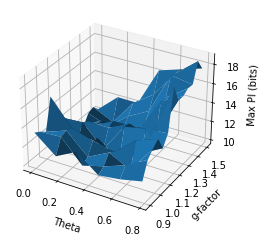

In [137]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(np.array([thetas]*gs.size), np.transpose(np.array([gs]*thetas.size)), max_pis_mean)
plt.xlabel('Theta')
plt.ylabel('g-factor')
ax.set_zlabel('Max PI (bits)')

**Testing if nonlinearity in random PI is due to recurrent structure of network by offsetting diagonal entries of weight matrix**

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1443.99it/s]


1
2
3
4
5
6
7
8


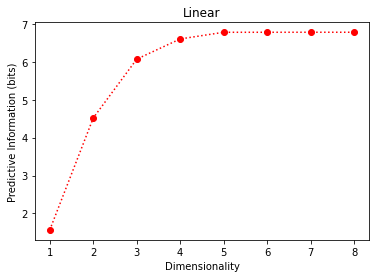

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1472.20it/s]


1
2
3
4
5
6
7
8


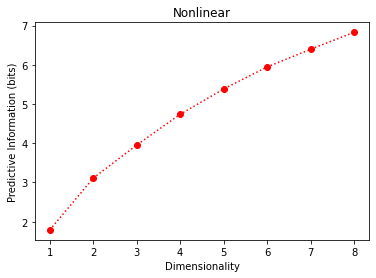

In [96]:
time = 10000
cases = [1,0]
for case in cases:
    weight_matrix = np.random.normal(0, 0.7/np.sqrt(num_nodes), (num_nodes, num_nodes))
    #Offsetting weight matrix
    c=timestep/time_constant
    for i in range(num_nodes):
        weight_matrix[i,i] -= (1-c)/c
        
        
    inputs = network.convert(time, input_funcs)
    network = RNN(weight_matrix, connectivity_matrix, init_activations, output_weight_matrix, time_constant = time_constant,
             timestep = timestep, activation_func = tf.keras.layers.LeakyReLU(alpha=case), output_nonlinearity = lambda x : x)
    _,activations = network.simulate(time, inputs, input_weight_matrix)
    activations = [activation.numpy() for activation in activations]
    activations = np.asarray(activations)
    
    dca_model = DCA(T=10, d=256)
    dca_model.estimate_data_statistics(activations)

    ds = np.arange(1,9,1)
    pis_per_dim = np.zeros(ds.size)
    for ii, dim in enumerate(ds):
        print(dim)
        dca_model.fit_projection(d=dim)
        pis_per_dim[ii] = dca_model.score()
    plt.plot(ds, pis_per_dim,'ro:')
    plt.xlabel('Dimensionality')
    plt.ylabel('Predictive Information (bits)')
    if case == 0:
        plt.title('Nonlinear')
    elif case == 1:
        plt.title('Linear')
    plt.show()

## max g-factor and max eigenvalue when dynamics blow up for each nonlinearity

In [58]:
num_avg=10
gs = np.arange(1,2,0.01)
thetas = np.arange(0,np.pi/4+np.pi/50, np.pi/20)
num_nodes=256
time_constant=100
timestep=10
time = 10000
init_activations = tf.constant(np.zeros((num_nodes, 1)))
#dont care about the output
output_weight_matrix = tf.constant(np.zeros((1, num_nodes)))
connectivity_matrix = np.ones((num_nodes, num_nodes))
noise_strength = 0.01

def noise(time):
    return np.sqrt(2 * time_constant/timestep) * noise_strength * np.random.normal(0, 1)

input_funcs = [noise]
input_weight_matrix = tf.constant(np.ones((1,num_nodes)))

In [60]:
max_factor_means = []
max_factor_stds=[]
max_eigenval_means = []
max_eigenval_stds=[]
for theta in thetas:
    max_factors=[]
    max_eigenvals = []
    for i in tqdm(range(num_avg)):
        blow_up=False
        idx=0
        while not blow_up:
            if idx == gs.size:
                g=10
                max_eigenval=10
                break
            g=gs[idx]
            idx+=1
            weight_matrix = np.random.normal(0, g/np.sqrt(num_nodes), (num_nodes, num_nodes))
            max_eigenval = np.max(np.abs(np.linalg.eigvals(weight_matrix)))
            network = RNN(weight_matrix, connectivity_matrix, init_activations, output_weight_matrix, time_constant = time_constant,
                     timestep = timestep, activation_func = tf.keras.layers.LeakyReLU(alpha=np.tan(theta)), output_nonlinearity = lambda x : x)
            inputs = network.convert(time, input_funcs)
            _,activations = network.simulate(time, inputs, input_weight_matrix, disable_progress_bar = True) 
            activations = [activation.numpy() for activation in activations]
            activations = np.asarray(activations)
            avg_activation = np.mean(np.abs(activations), axis=1)
            if max(avg_activation>=5):
                blow_up=True
        max_factors.append(g)
        max_eigenvals.append(max_eigenval)
    max_factor_means.append(np.mean(max_factors))
    max_factor_stds.append(np.std(max_factors))
    max_eigenval_means.append(np.mean(max_eigenvals))
    max_eigenval_stds.append(np.std(max_eigenvals))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:54<00:00,  5.42s/it]


In [61]:
max_factor_means = np.array(max_factor_means)
max_factor_stds = np.array(max_factor_stds)
max_eigenval_means = np.array(max_eigenval_means)
max_eigenval_stds = np.array(max_eigenval_stds)

#np.save('random_net_mean_factors', max_factor_means)
#np.save('random_net_std_factors', max_factor_stds)
#np.save('random_net_mean_eigenval', max_eigenval_means)
#np.save('random_net_std_eigenval', max_eigenval_stds)

In [62]:
max_factor_means = np.load('random_net_mean_factors.npy')
max_factor_stds = np.load('random_net_std_factors.npy')
max_eigenval_means = np.load('random_net_mean_eigenval.npy')
max_eigenval_stds = np.load('random_net_std_eigenval.npy')

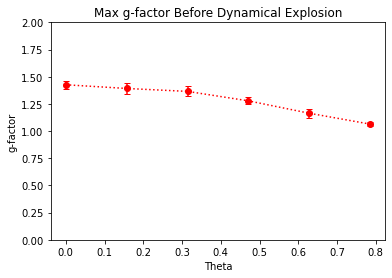

In [63]:
plt.errorbar(thetas, max_factor_means, yerr=max_factor_stds, capsize=3, fmt='ro:')
plt.title('Max g-factor Before Dynamical Explosion')
plt.xlabel('Theta')
plt.ylabel('g-factor')
plt.ylim(0,2)
plt.show()

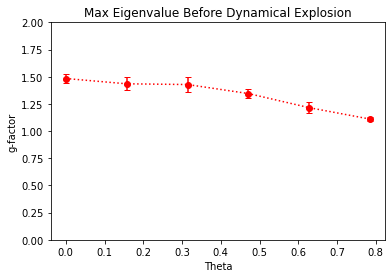

In [74]:
plt.errorbar(thetas, max_eigenval_means, yerr=max_eigenval_stds, capsize=3, fmt='ro:')
plt.title('Max Eigenvalue Before Dynamical Explosion')
plt.xlabel('Theta')
plt.ylabel('Eigenvalue')
plt.ylim(0,2)
plt.show()

# Loading Trained Networks

Loading the 10 weight matrices for each task

## Perception Task

In [121]:
weight_histories_perception = []
num_networks=10
for i in range(num_networks):
    print(i)
    with open('Perception_Task/relu/256_nodes/weight_history_{0}.json'.format(i)) as f:
        weight_history = json.load(f)
    weight_histories_perception.append(weight_history)

0
1
2
3
4
5
6
7
8
9


**Defining the 10 perception networks**

In [122]:
num_nodes = 256
time_constant = 100 #ms
timestep = 10 #ms
noise_strength = 0.01
input_weights_perception = []
perception_networks = []
for i in range(num_networks):
    weight_history = weight_histories_perception[i]
    noise_weights = np.array(weight_history['noise weights'])
    bias_weights = np.array(weight_history['bias'])
    input_weights = np.array(weight_history['input weights'])
    output_weight_matrix = np.array(weight_history['output weights'])
    connectivity_matrix = np.array(weight_history['connectivity matrix'])
    final_weights = np.array(weight_history['trained weights'][-1])


    weight_matrix = tf.Variable(final_weights)
    connectivity_matrix = tf.constant(connectivity_matrix)

    input_weight_matrix = tf.constant(np.vstack((bias_weights, noise_weights, input_weights)))   
    input_weights_perception.append(input_weight_matrix)
    init_activations = tf.constant(np.zeros((num_nodes, 1)))
    output_weight_matrix = tf.constant(output_weight_matrix)

    network = RNN(weight_matrix, connectivity_matrix, init_activations, output_weight_matrix, time_constant = time_constant,
                 timestep = timestep,activation_func = keras.activations.relu, output_nonlinearity = lambda x : x)
    perception_networks.append(network)

**Defining the 10 untrained Perception Networks**

In [123]:
num_nodes = 256
time_constant = 100 #ms
timestep = 10 #ms
noise_strength = 0.01
input_weights_perception = []
perception_networks_untrained = []
for i in range(num_networks):
    weight_history = weight_histories_perception[i]
    noise_weights = np.array(weight_history['noise weights'])
    bias_weights = np.array(weight_history['bias'])
    input_weights = np.array(weight_history['input weights'])
    output_weight_matrix = np.array(weight_history['output weights'])
    connectivity_matrix = np.array(weight_history['connectivity matrix'])
    final_weights = np.array(weight_history['trained weights'][0])


    weight_matrix = tf.Variable(final_weights)
    connectivity_matrix = tf.constant(connectivity_matrix)

    input_weight_matrix = tf.constant(np.vstack((bias_weights, noise_weights, input_weights)))   
    input_weights_perception.append(input_weight_matrix)
    init_activations = tf.constant(np.zeros((num_nodes, 1)))
    output_weight_matrix = tf.constant(output_weight_matrix)

    network = RNN(weight_matrix, connectivity_matrix, init_activations, output_weight_matrix, time_constant = time_constant,
                 timestep = timestep,activation_func = keras.activations.relu, output_nonlinearity = lambda x : x)
    perception_networks_untrained.append(network)

## Decision Task

In [124]:
weight_histories_decision = []
for i in range(num_networks):
    print(i)
    with open('Decision_Task/relu/256_nodes/weight_history_{0}.json'.format(i)) as f:
        weight_history = json.load(f)
    weight_histories_decision.append(weight_history)

0
1
2
3
4
5
6
7
8
9


**Defining the 10 decision networks**

In [125]:
num_nodes = 256
time_constant = 100 #ms
timestep = 10 #ms
noise_strength = 0.01
input_weights_decision = []
decision_networks = []
for i in range(num_networks):
    weight_history = weight_histories_decision[i]
    noise_weights = np.array(weight_history['noise weights'])
    bias_weights = np.array(weight_history['bias'])
    input1_weights = np.array(weight_history['input1 weights'])
    input2_weights = np.array(weight_history['input2 weights'])
    output_weight_matrix = np.array(weight_history['output weights'])
    connectivity_matrix = np.array(weight_history['connectivity matrix'])
    final_weights = np.array(weight_history['trained weights'][-1])


    weight_matrix = tf.Variable(final_weights)
    connectivity_matrix = tf.constant(connectivity_matrix)

    input_weight_matrix = tf.constant(np.vstack((bias_weights, noise_weights, input1_weights, input2_weights)))   
    input_weights_decision.append(input_weight_matrix)
    init_activations = tf.constant(np.zeros((num_nodes, 1)))
    output_weight_matrix = tf.constant(output_weight_matrix)

    network = RNN(weight_matrix, connectivity_matrix, init_activations, output_weight_matrix, time_constant = time_constant,
                 timestep = timestep,activation_func = keras.activations.relu, output_nonlinearity = lambda x : x)
    decision_networks.append(network)

**Defining the 10 untrained Decision Networks**

In [126]:
num_nodes = 256
time_constant = 100 #ms
timestep = 10 #ms
noise_strength = 0.01
input_weights_decision = []
decision_networks_untrained = []
for i in range(num_networks):
    weight_history = weight_histories_decision[i]
    noise_weights = np.array(weight_history['noise weights'])
    bias_weights = np.array(weight_history['bias'])
    input1_weights = np.array(weight_history['input1 weights'])
    input2_weights = np.array(weight_history['input2 weights'])
    output_weight_matrix = np.array(weight_history['output weights'])
    connectivity_matrix = np.array(weight_history['connectivity matrix'])
    final_weights = np.array(weight_history['trained weights'][0])


    weight_matrix = tf.Variable(final_weights)
    connectivity_matrix = tf.constant(connectivity_matrix)

    input_weight_matrix = tf.constant(np.vstack((bias_weights, noise_weights, input1_weights, input2_weights)))   
    input_weights_decision.append(input_weight_matrix)
    init_activations = tf.constant(np.zeros((num_nodes, 1)))
    output_weight_matrix = tf.constant(output_weight_matrix)

    network = RNN(weight_matrix, connectivity_matrix, init_activations, output_weight_matrix, time_constant = time_constant,
                 timestep = timestep,activation_func = keras.activations.relu, output_nonlinearity = lambda x : x)
    decision_networks_untrained.append(network)

In [127]:
time=10000

def bias(time):
    return 1
def noise(time):
    return np.sqrt(2 * time_constant/timestep) * noise_strength * np.random.normal(0, 1)

# Perception Weight Matrices

## Max Pi vs Nonlinearity for trained vs untrained network (only noise+bias input)

In [128]:
thetas = np.arange(0,np.pi/4+np.pi/50, np.pi/20)
trained_max_pis_means = []
trained_max_pis_stds = []

untrained_max_pis_means = []
untrained_max_pis_stds = []

for theta in thetas:
    trained_max_pis = []
    untrained_max_pis = []
    for i in tqdm(range(len(perception_networks))):
        trained_network = perception_networks[i]
        untrained_network = perception_networks_untrained[i]
        trained_network.activation_func = tf.keras.layers.LeakyReLU(alpha=np.tan(theta))
        untrained_network.activation_func = tf.keras.layers.LeakyReLU(alpha=np.tan(theta))
        trained_network.reset_activations()
        untrained_network.reset_activations()
        
        input_funcs = [bias, noise]
        inputs = network.convert(time, input_funcs)
        outputs, trained_activations = trained_network.simulate(time, inputs, input_weights_perception[i][:2], disable_progress_bar=True)
        trained_activations = [activation.numpy() for activation in trained_activations]
        trained_activations = np.asarray(trained_activations)
        
        outputs, untrained_activations = untrained_network.simulate(time, inputs, input_weights_perception[i][:2], disable_progress_bar=True)
        untrained_activations = [activation.numpy() for activation in untrained_activations]
        untrained_activations = np.asarray(untrained_activations)
        
        dca_model = DCA(T=10, d=256)
        dca_model.estimate_data_statistics(trained_activations)
        trained_max_pis.append(dca_model.score())
        dca_model.estimate_data_statistics(untrained_activations)
        untrained_max_pis.append(dca_model.score())
    trained_max_pis_means.append(np.mean(trained_max_pis))
    trained_max_pis_stds.append(np.std(trained_max_pis))
    untrained_max_pis_means.append(np.mean(untrained_max_pis))
    untrained_max_pis_stds.append(np.std(untrained_max_pis))
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [07:32<00:00, 45.29s/it]


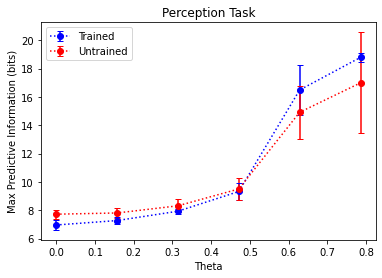

In [129]:
plt.errorbar(thetas, trained_max_pis_means, yerr = trained_max_pis_stds, fmt='bo:', capsize=3, label='Trained')
plt.errorbar(thetas, untrained_max_pis_means, yerr = untrained_max_pis_stds, fmt='ro:', capsize=3, label='Untrained')
plt.legend()
plt.xlabel('Theta')
plt.ylabel('Max Predictive Information (bits)')
plt.title('Perception Task')
plt.show()

# Decision Weight Matrices

## Pi vs Nonlinearity for trained vs untrained matrix (only noise+bias input)

In [131]:
thetas = np.arange(0,np.pi/4+np.pi/50, np.pi/20)
trained_max_pis_means = []
trained_max_pis_stds = []

untrained_max_pis_means = []
untrained_max_pis_stds = []

for theta in thetas:
    trained_max_pis = []
    untrained_max_pis = []
    for i in tqdm(range(len(decision_networks))):
        trained_network = decision_networks[i]
        untrained_network = decision_networks_untrained[i]
        trained_network.activation_func = tf.keras.layers.LeakyReLU(alpha=np.tan(theta))
        untrained_network.activation_func = tf.keras.layers.LeakyReLU(alpha=np.tan(theta))
        trained_network.reset_activations()
        untrained_network.reset_activations()
        
        input_funcs = [bias, noise]
        inputs = network.convert(time, input_funcs)
        outputs, trained_activations = trained_network.simulate(time, inputs, input_weights_decision[i][:2], disable_progress_bar=True)
        trained_activations = [activation.numpy() for activation in trained_activations]
        trained_activations = np.asarray(trained_activations)
        
        outputs, untrained_activations = untrained_network.simulate(time, inputs, input_weights_decision[i][:2], disable_progress_bar=True)
        untrained_activations = [activation.numpy() for activation in untrained_activations]
        untrained_activations = np.asarray(untrained_activations)
        
        dca_model = DCA(T=10, d=256)
        dca_model.estimate_data_statistics(trained_activations)
        trained_max_pis.append(dca_model.score())
        dca_model.estimate_data_statistics(untrained_activations)
        untrained_max_pis.append(dca_model.score())
    trained_max_pis_means.append(np.mean(trained_max_pis))
    trained_max_pis_stds.append(np.std(trained_max_pis))
    untrained_max_pis_means.append(np.mean(untrained_max_pis))
    untrained_max_pis_stds.append(np.std(untrained_max_pis))
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [06:42<00:00, 40.26s/it]


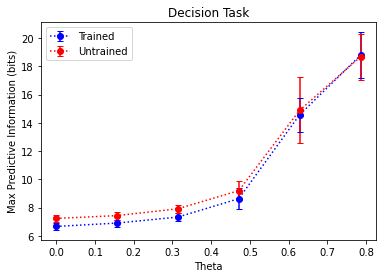

In [132]:
plt.errorbar(thetas, trained_max_pis_means, yerr = trained_max_pis_stds, fmt='bo:', capsize=3, label='Trained')
plt.errorbar(thetas, untrained_max_pis_means, yerr = untrained_max_pis_stds, fmt='ro:', capsize=3, label='Untrained')
plt.legend()
plt.xlabel('Theta')
plt.ylabel('Max Predictive Information (bits)')
plt.title('Decision Task')
plt.show()